**Results Analysis:**
*   Dataset stats
*   embeddings
*   clustering
*   UMAP plots
*   TF-IDF top-term







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Input dataset:
IN_CSV = "/content/drive/MyDrive/combined_data_FIXED.csv"
MANIFEST = "/content/drive/MyDrive/image_manifest.csv"

# Output root:
ROOT = "/content/drive/MyDrive/msc_final_dataset"
import os
os.makedirs(ROOT, exist_ok=True)
print("Output root:", ROOT)

# Core outputs
TRIMMED   = f"{ROOT}/final_trimmed.csv"
BALANCED  = f"{ROOT}/final_balanced.csv"
STATS_TXT = f"{ROOT}/dataset_stats.txt"

# Image merge + OCR outputs
WITH_IMG  = f"{ROOT}/final_with_images.csv"
WITH_OCR  = f"{ROOT}/final_with_images_ocr.csv"

# Emoji augmentation
EMOJI_AUG = WITH_OCR

# Annotation sheet
ANN_SHEET = f"{ROOT}/annotation_sheet_v1.csv"

# Embeddings / analysis outputs
EMB_DIR   = f"{ROOT}/embeddings"
PLOTS_DIR = f"{ROOT}/plots"
os.makedirs(EMB_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

Mounted at /content/drive
Output root: /content/drive/MyDrive/msc_final_dataset


In [ ]:
!pip -q install pandas numpy

import pandas as pd, numpy as np
from urllib.parse import urlparse, parse_qs, unquote

MAX_REDDIT  = 2000
MAX_TWITTER = 5000
SUBREDDIT_WHITELIST = []  # ["memes","wholesomememes","relationships","offmychest"]

df = pd.read_csv(IN_CSV)
print("Rows before:", len(df))

# Normalize platform
df["Social_Media_Type"] = df["Social_Media_Type"].astype(str).str.strip().str.title()
is_twitter = df["Social_Media_Type"].eq("Twitter")
is_reddit  = df["Social_Media_Type"].eq("Reddit")

# Subcommunity_Tag
df["Subcommunity_Tag"] = df["Subcommunity_Tag"].astype(str)
df.loc[is_twitter, "Subcommunity_Tag"] = "Twitter"
df.loc[is_reddit & df["Subcommunity_Tag"].isin(["", "nan", "NaN", "None"]), "Subcommunity_Tag"] = "Unknown"

# Ensure Emoji column exists and is str
if "Emoji" not in df.columns:
    df["Emoji"] = ""
df["Emoji"] = df["Emoji"].astype(str).fillna("")

# Clean Reddit image references
def unwrap_and_clean(cell: str) -> str:
    if not isinstance(cell, str) or not cell.strip(): return ""
    raw = unquote(cell).replace("&amp;","&")
    parts = [p.strip() for p in raw.split(";") if p.strip()]
    out = []
    for p in parts:
        if "reddit.com/media?url=" in p:
            try:
                inner = parse_qs(urlparse(p).query).get("url", [])
                out += [unquote(x).replace("&amp;","&") for x in inner]
            except Exception:
                pass
        else:
            out.append(p)
    has_i = any("i.redd.it" in u.lower() for u in out)
    has_prev = any("preview.redd.it" in u.lower() for u in out)
    if has_i and has_prev:
        out = [u for u in out if "preview.redd.it" in u.lower()]
    seen, clean = set(), []
    for u in out:
        if u and u not in seen:
            seen.add(u); clean.append(u)
    return ";".join(clean[:3])

if "Image_Reference" in df.columns:
    df["Image_Reference"] = df["Image_Reference"].apply(unwrap_and_clean)
    df["Image_Reference"] = df["Image_Reference"].replace({"": np.nan})

# Drop irrelevant Reddit rows
def text_useless(x: str) -> bool:
    if not isinstance(x, str): return True
    t = x.strip().lower()
    if t in ["", "removed", "deleted", "[removed]", "[deleted]"]: return True
    if t.startswith("http://") or t.startswith("https://"): return True
    return False

drop_no_content = is_reddit & df["Text"].isna() & df["Image_Reference"].isna()
drop_useless    = is_reddit & df["Text"].apply(text_useless)
print("Drop counts (Reddit): no_content =", int(drop_no_content.sum()), "| useless =", int(drop_useless.sum()))
df = df[~(drop_no_content | drop_useless)].copy()

# Infer Modality_Type
def infer_mod(row):
    m = row.get("Modality_Type")
    m = m.strip().lower() if isinstance(m, str) else ""
    has_text = isinstance(row.get("Text"), str) and row["Text"].strip() != ""
    has_img  = isinstance(row.get("Image_Reference"), str) and row["Image_Reference"].strip() != ""
    if "text+image" in m: return "Text+Image"
    if "image-only" in m or m == "image": return "Image-only"
    if "text-only" in m or m == "text": return "Text-only"
    if has_text and has_img: return "Text+Image"
    if has_img and not has_text: return "Image-only"
    return "Text-only" if has_text else None

df["Modality_Type"] = df.apply(infer_mod, axis=1)

# Optional whitelist
if SUBREDDIT_WHITELIST:
    df = df[~is_reddit | df["Subcommunity_Tag"].str.lower().isin([s.lower() for s in SUBREDDIT_WHITELIST])]

# Cap Reddit
reddit  = df[df["Social_Media_Type"]=="Reddit"].copy()
twitter = df[df["Social_Media_Type"]=="Twitter"].copy()
if len(reddit) > MAX_REDDIT:
    reddit = reddit.sample(MAX_REDDIT, random_state=42)

trimmed = pd.concat([twitter, reddit], ignore_index=True)
trimmed.to_csv(TRIMMED, index=False)
print("Saved trimmed →", TRIMMED, "| rows:", len(trimmed))

# Downsample Twitter
twitter = trimmed[trimmed["Social_Media_Type"]=="Twitter"].copy()
reddit  = trimmed[trimmed["Social_Media_Type"]=="Reddit"].copy()
if len(twitter) > MAX_TWITTER:
    twitter = twitter.sample(MAX_TWITTER, random_state=42)

balanced = pd.concat([twitter, reddit], ignore_index=True)
balanced.to_csv(BALANCED, index=False)
print("Saved balanced →", BALANCED, "| rows:", len(balanced))

Rows before: 28666
Drop counts (Reddit): no_content = 0 | useless = 0
Saved trimmed → /content/drive/MyDrive/msc_final_dataset/final_trimmed.csv | rows: 28666
Saved balanced → /content/drive/MyDrive/msc_final_dataset/final_balanced.csv | rows: 5966


In [ ]:
import pandas as pd

final = pd.read_csv(BALANCED)

lines = []
lines.append(f"Input file: {IN_CSV}")
lines.append(f"Balanced rows: {len(final)}")
lines.append("\n=== Platform Counts ===")
lines.append(str(final["Social_Media_Type"].value_counts()))
lines.append("\n=== Modality Counts ===")
lines.append(str(final["Modality_Type"].value_counts(dropna=False)))
if "Emotion_Label" in final.columns:
    lines.append("\n=== Weak Label distribution (head) ===")
    lines.append(str(final["Emotion_Label"].value_counts(dropna=False).head(15)))
if "Subcommunity_Tag" in final.columns:
    lines.append("\n=== Top 10 Subcommunity_Tag ===")
    lines.append(str(final["Subcommunity_Tag"].value_counts(dropna=False).head(10)))
if "Emoji" in final.columns:
    lines.append("\n=== Emoji coverage ===")
    lines.append(f"non-empty rows: {final['Emoji'].astype(str).str.strip().ne('').sum()}")

report = "\n".join(lines)
print(report)
with open(STATS_TXT, "w") as f:
    f.write(report)
print("\nStats written →", STATS_TXT)

Input file: /content/drive/MyDrive/combined_data_FIXED.csv
Balanced rows: 5966

=== Platform Counts ===
Social_Media_Type
Twitter    5000
Reddit      966
Name: count, dtype: int64

=== Modality Counts ===
Modality_Type
Text-only     5475
Image-only     452
Text+Image      39
Name: count, dtype: int64

=== Weak Label distribution (head) ===
Emotion_Label
NaN                5929
Joy                   7
Sadness               4
Surprise              3
Trust                 3
Anger                 3
Fear                  3
Resignation           2
Disapproved           2
Anticipation          2
Trust/Belonging       2
Humor                 1
Indifferent           1
Temptation            1
Awareness/Trust       1
Name: count, dtype: int64

=== Top 10 Subcommunity_Tag ===
Subcommunity_Tag
Twitter           5000
wholesomememes     250
relationships      248
memes              244
offmychest         224
Name: count, dtype: int64

=== Emoji coverage ===
non-empty rows: 5966

Stats written → /cont

In [ ]:
import os, pandas as pd, numpy as np

if not os.path.exists(MANIFEST):
    raise FileNotFoundError("MANIFEST not found. Set MANIFEST path correctly.")

df = pd.read_csv(BALANCED)
man = pd.read_csv(MANIFEST).rename(columns={"url":"Image_Reference","local_path":"Image_Local_Path"})
man = man.drop_duplicates("Image_Reference", keep="first")

merged = df.merge(man[["Image_Reference","Image_Local_Path","status"]], on="Image_Reference", how="left")
merged.loc[merged["status"].ne("ok"), "Image_Local_Path"] = np.nan
merged.drop(columns=["status"], inplace=True, errors="ignore")
merged.to_csv(WITH_IMG, index=False)

print("Saved with images →", WITH_IMG, "| rows:", len(merged))
print("Rows with local images:", merged["Image_Local_Path"].notna().sum())

Saved with images → /content/drive/MyDrive/msc_final_dataset/final_with_images.csv | rows: 5966
Rows with local images: 0


In [ ]:
# OCR deps
!apt -y install tesseract-ocr >/dev/null
!pip -q install pytesseract pillow tqdm

import os, pandas as pd, numpy as np
from PIL import Image, ImageFile
import pytesseract
from tqdm import tqdm

Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

df = pd.read_csv(WITH_IMG)
if "OCR_Text" not in df.columns:
    df["OCR_Text"] = ""
else:
    df["OCR_Text"] = df["OCR_Text"].astype(str).fillna("")

def ocr_one(local_paths: str) -> str:
    if not isinstance(local_paths, str) or not local_paths.strip():
        return ""
    first = local_paths.split(";")[0].strip()
    if not os.path.exists(first):
        return ""
    try:
        img = Image.open(first).convert("RGB")
        text = pytesseract.image_to_string(img)
        return " ".join(str(text).split())
    except Exception:
        return ""

mask = df["Image_Local_Path"].notna()
todo_idx = df[mask & (df["OCR_Text"].astype(str).str.strip() == "")].index

for i in tqdm(todo_idx, desc="OCR images"):
    df.at[i, "OCR_Text"] = ocr_one(df.at[i, "Image_Local_Path"])

def combine_text(row):
    t = (row.get("Text") or "").strip()
    o = (row.get("OCR_Text") or "").strip()
    return (t + ("\n\n" + o if (t and o) else (o if o else ""))).strip()

df["Text_Combined"] = df.apply(combine_text, axis=1)
df.to_csv(WITH_OCR, index=False)

print("Saved with OCR →", WITH_OCR)
print("Has local images:", int(df["Image_Local_Path"].notna().sum()))
print("OCR non-empty:", int(df["OCR_Text"].astype(str).str.strip().ne("").sum()))
print("Any text (Text or OCR):", int(df["Text_Combined"].astype(str).str.strip().ne("").sum()))

OCR images: 0it [00:00, ?it/s]

Saved with OCR → /content/drive/MyDrive/msc_final_dataset/final_with_images_ocr.csv
Has local images: 0
OCR non-empty: 0
Any text (Text or OCR): 5966


Debugging missing images: OCR didn't link

In [ ]:
ROOT = "/content/drive/MyDrive/msc_final_dataset"
BALANCED = f"{ROOT}/final_balanced.csv"              # current dataset
WITH_IMG = f"{ROOT}/final_with_images.csv"
MANIFEST = "/content/drive/MyDrive/image_manifest.csv"

import os, pandas as pd, numpy as np, re
from urllib.parse import urlparse, parse_qs, unquote
from glob import glob

# Initial checks of files:
print("Exists(BALANCED):", os.path.exists(BALANCED))
print("Exists(MANIFEST):", os.path.exists(MANIFEST))
if not os.path.exists(MANIFEST):
    print("\nMANIFEST was not found. Searching Drive for likely files...")
    candidates = glob("/content/drive/MyDrive/**/image_manifest*.csv", recursive=True)
    for c in candidates[:10]:
        print(" -", c)
    raise FileNotFoundError("Manifest not found at MANIFEST; pick the correct path from the list above.")

df = pd.read_csv(BALANCED)
man = pd.read_csv(MANIFEST)

# standardize manifest columns
col_map = {c.lower(): c for c in man.columns}
url_col = col_map.get("url") or "url"
path_col = col_map.get("local_path") or "local_path"
status_col = col_map.get("status") if "status" in col_map else None

needed = [url_col, path_col] + ([status_col] if status_col else [])
missing = [c for c in [url_col, path_col] if c not in man.columns]
if missing:
    raise ValueError(f"Manifest missing required columns: {missing} (found: {list(man.columns)})")

print("\nRows in dataset:", len(df))
print("Rows with non-null Image_Reference:", df["Image_Reference"].notna().sum())
print("Rows in manifest:", len(man))
print("Example manifest rows:\n", man[[url_col, path_col]].head(3))

# normalizaiton:
def first_url(cell: str) -> str:
    if not isinstance(cell, str) or not cell.strip(): return ""
    # Take the first URL if the cell is semicolon-separated
    return cell.split(";")[0].strip()

def unwrap_media(u: str) -> str:
    try:
        if "reddit.com/media?url=" in u:
            inner = parse_qs(urlparse(u).query).get("url", [])
            if inner: return unquote(inner[0])
    except Exception:
        pass
    return u

def strip_query(u: str) -> str:
    try:
        p = urlparse(u)
        # Drop query & fragment
        return f"{p.scheme}://{p.netloc}{p.path}"
    except Exception:
        return u

def host_normalize(u: str) -> str:
    if not isinstance(u, str) or not u: return ""
    u = unquote(u).strip()
    if not u: return ""
    try:
        p = urlparse(u)
        host = (p.netloc or "").lower().replace("www.", "")
        path = p.path
        # Treat i.redd.it and preview.redd.it the same for matching by path
        if host in ("i.redd.it", "preview.redd.it"):
            return f"redd.it{path}"
        return f"{host}{path}"
    except Exception:
        return u.strip().lower()

def normalize(u: str) -> str:
    if not isinstance(u, str): return ""
    u = first_url(u)
    u = unwrap_media(u)
    u = strip_query(u)
    return host_normalize(u)

# Build normalized keys
df["_imgref_norm"] = df["Image_Reference"].astype(str).apply(normalize)
man["_url_norm"]   = man[url_col].astype(str).apply(normalize)

# Drop empties
df["_imgref_norm"].replace({"nan":"", "None":""}, inplace=True)
man["_url_norm"].replace({"nan":"", "None":""}, inplace=True)

# Deduplicate manifest on normalized URL
man_dedup = man.dropna(subset=["_url_norm"]).copy()
man_dedup = man_dedup[man_dedup["_url_norm"] != ""].drop_duplicates("_url_norm", keep="first")

# Merge output with normalization:
merged = df.merge(
    man_dedup[["_url_norm", path_col] + ([status_col] if status_col else [])],
    left_on="_imgref_norm",
    right_on="_url_norm",
    how="left"
)

# Choose final path:
def choose_path(p):
    if isinstance(p, str) and p.strip() and os.path.exists(p.strip()):
        return p.strip()
    return np.nan

merged["Image_Local_Path"] = merged[path_col].apply(choose_path)

# If manifest had a status column(?)
if status_col and status_col in merged.columns:
    bad = merged[status_col].astype(str).str.lower().ne("ok")
    merged.loc[bad, "Image_Local_Path"] = np.nan

# Clean up helper columns
merged.drop(columns=["_imgref_norm","_url_norm"], inplace=True, errors="ignore")

merged.to_csv(WITH_IMG, index=False)
print("\nSaved fixed merge →", WITH_IMG)
print("Rows with local images (existing files):", merged["Image_Local_Path"].notna().sum())

# Show a few successful matches for sanity
ok_rows = merged[merged["Image_Local_Path"].notna()].head(5)
print("\nSample matches:")
display(ok_rows[["Image_Reference","Image_Local_Path"]])

Exists(BALANCED): True
Exists(MANIFEST): True

Rows in dataset: 5966
Rows with non-null Image_Reference: 491
Rows in manifest: 574
Example manifest rows:
               url local_path
0             NaN        NaN
1  joy_meme_1.jpg        NaN
2  joy_meme_6.jpg        NaN


/tmp/ipython-input-3367337373.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["_imgref_norm"].replace({"nan":"", "None":""}, inplace=True)
/tmp/ipython-input-3367337373.py:94: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpla


Saved fixed merge → /content/drive/MyDrive/msc_final_dataset/final_with_images.csv
Rows with local images (existing files): 462

Sample matches:


,Image_Reference,Image_Local_Path
5473,https://preview.redd.it/2tfue5w4xnmf1.jpeg?aut...,/content/drive/MyDrive/dataset_images/9b8407ec...
5474,https://preview.redd.it/lddimzp35ulf1.jpeg?aut...,/content/drive/MyDrive/dataset_images/201bdc3f...
5475,https://preview.redd.it/awbb3usfrsjf1.jpeg?aut...,/content/drive/MyDrive/dataset_images/8c792487...
5476,https://preview.redd.it/n28z5er70rjf1.jpeg?aut...,/content/drive/MyDrive/dataset_images/01c01fc0...
5477,https://preview.redd.it/okjoujh6uajf1.jpeg?aut...,/content/drive/MyDrive/dataset_images/c10c17f1...


In [ ]:
# Paths
WITH_IMG = "/content/drive/MyDrive/msc_final_dataset/final_with_images.csv"
WITH_OCR = "/content/drive/MyDrive/msc_final_dataset/final_with_images_ocr.csv"

# Deps
!apt -y install tesseract-ocr >/dev/null
!pip -q install pytesseract pillow tqdm

import os, pandas as pd, numpy as np
from PIL import Image, ImageFile
import pytesseract
from tqdm import tqdm

Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

df = pd.read_csv(WITH_IMG)

# Ensure OCR_Text exists and is a string column
if "OCR_Text" not in df.columns:
    df["OCR_Text"] = ""
else:
    df["OCR_Text"] = df["OCR_Text"].astype(str).fillna("")

def ocr_one(local_paths: str) -> str:
    if not isinstance(local_paths, str) or not local_paths.strip():
        return ""
    first = local_paths.split(";")[0].strip()
    if not os.path.exists(first):
        return ""
    try:
        img = Image.open(first).convert("RGB")
        text = pytesseract.image_to_string(img)
        return " ".join(str(text).split())
    except Exception:
        return ""

mask = df["Image_Local_Path"].notna()
todo_idx = df[mask & (df["OCR_Text"].astype(str).str.strip() == "")].index

for i in tqdm(todo_idx, desc="OCR images"):
    df.at[i, "OCR_Text"] = ocr_one(df.at[i, "Image_Local_Path"])

# Build Text_Combined from Text + OCR_Text
def combine_text(row):
    t = (row.get("Text") or "").strip()
    o = (row.get("OCR_Text") or "").strip()
    return (t + ("\n\n" + o if (t and o) else (o if o else ""))).strip()

df["Text_Combined"] = df.apply(combine_text, axis=1)

df.to_csv(WITH_OCR, index=False)
print("Saved with OCR →", WITH_OCR)
print("Has local images:", int(df["Image_Local_Path"].notna().sum()))
print("OCR non-empty:", int(df["OCR_Text"].astype(str).str.strip().ne("").sum()))
print("Any text (Text or OCR):", int(df["Text_Combined"].astype(str).str.strip().ne("").sum()))

OCR images:  27%|██▋       | 125/462 [04:54<18:53,  3.36s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
OCR images:  75%|███████▌  | 348/462 [12:10<02:54,  1.53s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
OCR images:  79%|███████▉  | 366/462 [12:35<01:59,  1.25s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
OCR images:  89%|████████▊ | 409/462 [13:35<01:08,  1.30s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
OCR images: 100%|██████████| 462/462 [14:51<00:00,  

Saved with OCR → /content/drive/MyDrive/msc_final_dataset/final_with_images_ocr.csv
Has local images: 462
OCR non-empty: 376
Any text (Text or OCR): 5966


Find if emojis are recognized:

In [ ]:
import pandas as pd, re

PATH = "/content/drive/MyDrive/msc_final_dataset/final_with_images_ocr.csv"

emoji_re = re.compile(
    "["
    "\U0001F300-\U0001F5FF" "\U0001F600-\U0001F64F" "\U0001F680-\U0001F6FF"
    "\U0001F700-\U0001F77F" "\U0001F780-\U0001F7FF" "\U0001F800-\U0001F8FF"
    "\U0001F900-\U0001F9FF" "\U0001FA00-\U0001FAFF" "\U00002700-\U000027BF"
    "\U00002600-\U000026FF" "\U0000200D" "\U0000FE0F"
    "]+"
)

def extract_emojis(text: str) -> str:
    if not isinstance(text, str) or not text.strip(): return ""
    found = emoji_re.findall(text)
    if not found: return ""
    chars=[]
    for chunk in found:
        for ch in list(chunk):
            if emoji_re.match(ch): chars.append(ch)
    seen, out = set(), []
    for ch in chars:
        if ch not in seen:
            seen.add(ch); out.append(ch)
    return "".join(out)

df = pd.read_csv(PATH)
combined_src = (df["Text"].fillna("").astype(str) + "\n" + df["OCR_Text"].fillna("").astype(str)).str.strip()
df["Emoji_Extracted"] = [extract_emojis(s) for s in combined_src]

if "Emoji" not in df.columns:
    df["Emoji"] = ""
orig = df["Emoji"].astype(str).str.strip()
fill_mask = orig.eq("") | orig.str.lower().isin(["nan","none"])
df.loc[fill_mask, "Emoji"] = df.loc[fill_mask, "Emoji_Extracted"]

df.to_csv(PATH, index=False)
print("Emoji updated in:", PATH)
print("Non-empty Emoji rows:", df["Emoji"].astype(str).str.strip().ne("").sum())

Emoji updated in: /content/drive/MyDrive/msc_final_dataset/final_with_images_ocr.csv
Non-empty Emoji rows: 80


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/msc_final_dataset/final_with_images_ocr.csv")
print("Rows:", len(df))
print("Has local images:", df["Image_Local_Path"].notna().sum())
print("OCR non-empty:", df["OCR_Text"].astype(str).str.strip().ne("").sum())
print("Any text (Text or OCR):", df["Text_Combined"].astype(str).str.strip().ne("").sum())
print("\nBy modality:")
print(df["Modality_Type"].value_counts(dropna=False).to_string())

Rows: 5966
Has local images: 462
OCR non-empty: 5966
Any text (Text or OCR): 5966

By modality:
Modality_Type
Text-only     5475
Image-only     452
Text+Image      39


In [ ]:
import pandas as pd

DATA = "/content/drive/MyDrive/msc_final_dataset/final_with_images_ocr.csv"
df = pd.read_csv(DATA)

print("Rows:", len(df))
print("Columns:", df.columns.tolist())

df.head(5)[[
    "Text",
    "OCR_Text",
    "Text_Combined",
    "Emoji",
    "Image_Reference",
    "Image_Local_Path",
    "Modality_Type",
    "Social_Media_Type",
    "Subcommunity_Tag",
    "Emotion_Label"
]]

Rows: 5966
Columns: ['Text', 'Emotion_Label', 'Emoji', 'Image_Reference', 'Subcommunity_Tag', 'Modality_Type', 'Social_Media_Type', 'Source', 'Image_Local_Path', 'local_path', 'status', 'OCR_Text', 'Text_Combined', 'Emoji_Extracted']


,Text,OCR_Text,Text_Combined,Emoji,Image_Reference,Image_Local_Path,Modality_Type,Social_Media_Type,Subcommunity_Tag,Emotion_Label
0,Can`t find any pictures !!!,NaN,Can`t find any pictures !!!,NaN,NaN,NaN,Text-only,Twitter,Twitter,NaN
1,"RE: So, finally finished catching up with your...",NaN,"RE: So, finally finished catching up with your...",NaN,NaN,NaN,Text-only,Twitter,Twitter,NaN
2,*hugs*,NaN,*hugs*,NaN,NaN,NaN,Text-only,Twitter,Twitter,NaN
3,Feeling pretty good this morning! Lets hope it...,NaN,Feeling pretty good this morning! Lets hope it...,NaN,NaN,NaN,Text-only,Twitter,Twitter,NaN
4,i wish i had friends i could spend the night with,NaN,i wish i had friends i could spend the night with,NaN,NaN,NaN,Text-only,Twitter,Twitter,NaN


**Visual EDA - Analysis between modality distribution**

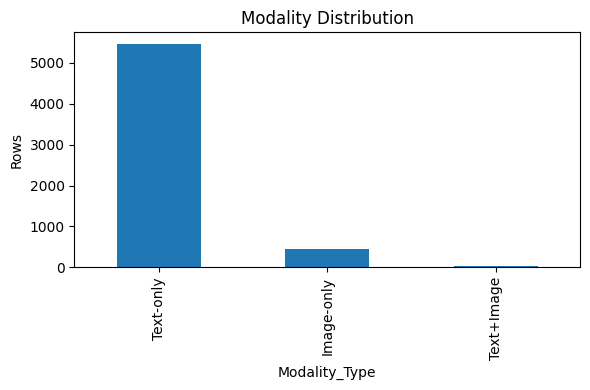

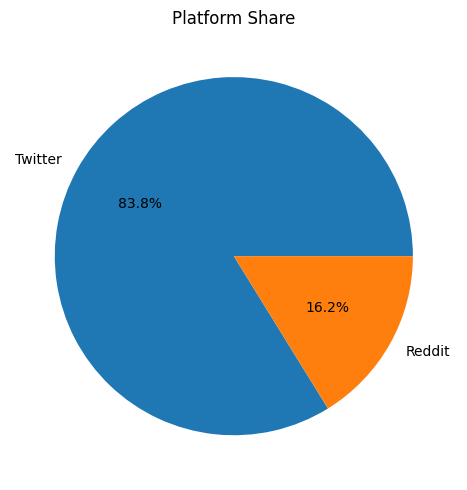

/tmp/ipython-input-3380247201.py:23: UserWarning: Glyph 129344 (\N{WILTED FLOWER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3380247201.py:23: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3380247201.py:23: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3380247201.py:23: UserWarning: Glyph 128149 (\N{TWO HEARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3380247201.py:23: UserWarning: Glyph 129309 (\N{HANDSHAKE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3380247201.py:23: UserWarning: Glyph 128062 (\N{PAW PRINTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3380247201.py:23: UserWarning: Glyph 128170 (\N{FLEXED BICEPS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3380247201.py:23: Us

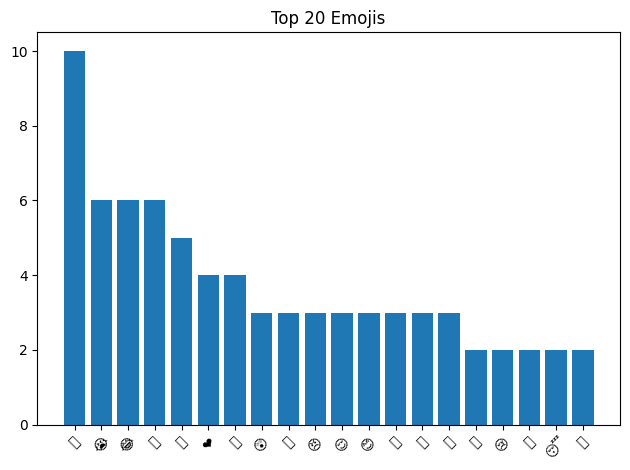

In [ ]:
import matplotlib.pyplot as plt

# Modality
df["Modality_Type"].value_counts().plot(kind="bar", figsize=(6,4), title="Modality Distribution")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()

# Platform
df["Social_Media_Type"].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(5,5), title="Platform Share")
plt.ylabel("")
plt.tight_layout()
plt.show()

# Emoji frequency (top 20)
from collections import Counter
all_emojis = "".join(df["Emoji"].dropna().astype(str))
top20 = Counter(all_emojis).most_common(20)
if top20:
    plt.bar([e for e,_ in top20],[c for _,c in top20])
    plt.title("Top 20 Emojis")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**First content analysis (word frequencies from Text_Combined)**

In [ ]:
import re
from collections import Counter

words = " ".join(df["Text_Combined"].dropna().astype(str)).lower()
tokens = re.findall(r"\b\w+\b", words)
top_words = Counter(tokens).most_common(20)
print("Top words:", top_words)

Top words: [('i', 14956), ('to', 8222), ('and', 7397), ('the', 6122), ('a', 5416), ('my', 4472), ('it', 4053), ('me', 3693), ('of', 3259), ('t', 3247), ('that', 3143), ('he', 3036), ('in', 2892), ('for', 2725), ('but', 2505), ('s', 2468), ('is', 2289), ('with', 2285), ('was', 2179), ('she', 2048)]


***Statistic Analysis:***

In [ ]:
import pandas as pd

DATA = "/content/drive/MyDrive/msc_final_dataset/final_with_images_ocr.csv"
df = pd.read_csv(DATA)

print("Rows:", len(df))
print("\nColumns:", df.columns.tolist())

print("\n=== Platform counts ===")
print(df["Social_Media_Type"].value_counts())

print("\n=== Modality counts ===")
print(df["Modality_Type"].value_counts())

print("\n=== Subcommunity (top 10) ===")
print(df["Subcommunity_Tag"].value_counts().head(10))

print("\n=== Emoji coverage ===")
print("Non-empty emoji rows:", df["Emoji"].astype(str).str.strip().ne("").sum())

Rows: 5966

Columns: ['Text', 'Emotion_Label', 'Emoji', 'Image_Reference', 'Subcommunity_Tag', 'Modality_Type', 'Social_Media_Type', 'Source', 'Image_Local_Path', 'local_path', 'status', 'OCR_Text', 'Text_Combined', 'Emoji_Extracted']

=== Platform counts ===
Social_Media_Type
Twitter    5000
Reddit      966
Name: count, dtype: int64

=== Modality counts ===
Modality_Type
Text-only     5475
Image-only     452
Text+Image      39
Name: count, dtype: int64

=== Subcommunity (top 10) ===
Subcommunity_Tag
Twitter           5000
wholesomememes     250
relationships      248
memes              244
offmychest         224
Name: count, dtype: int64

=== Emoji coverage ===
Non-empty emoji rows: 5966


In [ ]:
print("\n=== Weak Emotion labels (head) ===")
print(df["Emotion_Label"].value_counts(dropna=False).head(20))


=== Weak Emotion labels (head) ===
Emotion_Label
NaN                          5929
Joy                             7
Sadness                         4
Surprise                        3
Trust                           3
Anger                           3
Fear                            3
Resignation                     2
Disapproved                     2
Anticipation                    2
Trust/Belonging                 2
Humor                           1
Indifferent                     1
Temptation                      1
Awareness/Trust                 1
Anticipation/Relatability       1
Annoyed                         1
Name: count, dtype: int64


In [ ]:
print("\n=== Text-only example ===")
print(df[df["Modality_Type"]=="Text-only"].sample(3, random_state=42)[["Text","Emoji","Emotion_Label"]])

print("\n=== Image-only example ===")
print(df[df["Modality_Type"]=="Image-only"].sample(3, random_state=42)[["Image_Local_Path","OCR_Text","Emoji"]])

print("\n=== Text+Image example ===")
print(df[df["Modality_Type"]=="Text+Image"].sample(3, random_state=42)[["Text","OCR_Text","Emoji","Image_Local_Path"]])


=== Text-only example ===
                                                   Text Emoji Emotion_Label
5459  My mother(f51) is giving me(f17)the silent tre...   NaN           NaN
4375  congrats!!!  I highly doubt u`ll have buyer`s ...   NaN           NaN
1086  trying to decide what to do tonight. Study Che...   NaN           NaN

=== Image-only example ===
                                       Image_Local_Path  \
5808  /content/drive/MyDrive/dataset_images/e26a3413...   
5518  /content/drive/MyDrive/dataset_images/aa5c5997...   
5847  /content/drive/MyDrive/dataset_images/ca2a87e3...   

                                              OCR_Text Emoji  
5808                                               NaN   NaN  
5518  ee ea ae oe © Rise.Bloomshine & Rise-Bloom-Shine   NaN  
5847                       i Minowinen 10 cards el out   NaN  

=== Text+Image example ===
                                                   Text  \
5690    Daily Affirmation\n\nDoggo belongs to u/fshlady   
5708  

In [ ]:
from collections import Counter
import re

# Top words from combined text
words = " ".join(df["Text_Combined"].dropna().astype(str)).lower()
tokens = re.findall(r"\b\w+\b", words)
print("Top words:", Counter(tokens).most_common(20))

# Top emojis
all_emojis = "".join(df["Emoji"].dropna().astype(str))
print("Top emojis:", Counter(all_emojis).most_common(20))

Top words: [('i', 14956), ('to', 8222), ('and', 7397), ('the', 6122), ('a', 5416), ('my', 4472), ('it', 4053), ('me', 3693), ('of', 3259), ('t', 3247), ('that', 3143), ('he', 3036), ('in', 2892), ('for', 2725), ('but', 2505), ('s', 2468), ('is', 2289), ('with', 2285), ('was', 2179), ('she', 2048)]
Top emojis: [('🥀', 10), ('😭', 6), ('😂', 6), ('❌', 6), ('🙄', 5), ('❤', 4), ('💕', 4), ('😲', 3), ('🤝', 3), ('😠', 3), ('😌', 3), ('😊', 3), ('🐾', 3), ('💪', 3), ('💀', 3), ('🐶', 2), ('😢', 2), ('🤨', 2), ('😴', 2), ('🤷', 2)]


In [ ]:
mask = df["Text_Combined"].astype(str).str.strip().ne("") & df["Emoji"].astype(str).str.strip().eq("")
print("Rows with text but no emoji:", mask.sum())

Rows with text but no emoji: 0


See Text + Image modality data:

In [ ]:
import pandas as pd

DATA = "/content/drive/MyDrive/msc_final_dataset/final_with_images_ocr.csv"
df = pd.read_csv(DATA)

text_image = df[df["Modality_Type"]=="Text+Image"]

print("Text+Image count:", len(text_image))
text_image[["Text","OCR_Text","Text_Combined","Emoji","Image_Local_Path"]].head(10)

Text+Image count: 39


,Text,OCR_Text,Text_Combined,Emoji,Image_Local_Path
269,“Dog ran to the door when I came home”,NaN,“Dog ran to the door when I came home”,🐶,NaN
654,They didn’t even notice I left the group chat 😔,NaN,They didn’t even notice I left the group chat 😔,😢,NaN
1657,“He called me bro mid-argument”,NaN,“He called me bro mid-argument”,😠,NaN
2142,“Who thought this was a good idea?”,NaN,“Who thought this was a good idea?”,🤨,NaN
2339,“Accidentally liked their 2012 photo 😭”,NaN,“Accidentally liked their 2012 photo 😭”,😭,NaN
3440,“Could be worse”,NaN,“Could be worse”,🤷,NaN
3625,They left crumbs all over my bed 😠,NaN,They left crumbs all over my bed 😠,😠,NaN
3961,My friend saved me a seat without asking 😌,NaN,My friend saved me a seat without asking 😌,😌,NaN
3985,"“No thanks, I’ll pass”",NaN,"“No thanks, I’ll pass”",✋,NaN
4030,“Missed the last bus… and it’s raining”,NaN,“Missed the last bus… and it’s raining”,😢,NaN


In [ ]:
image_only = df[df["Modality_Type"]=="Image-only"]
with_text = image_only[image_only["OCR_Text"].astype(str).str.strip().ne("")]

print("Image-only rows with non-empty OCR text:", len(with_text))
with_text[["OCR_Text","Emoji","Image_Local_Path"]].head(10)

Image-only rows with non-empty OCR text: 452


,OCR_Text,Emoji,Image_Local_Path
2758,NaN,😏,NaN
2914,NaN,😴,NaN
5473,NaN,NaN,/content/drive/MyDrive/dataset_images/9b8407ec...
5474,NaN,NaN,/content/drive/MyDrive/dataset_images/201bdc3f...
5475,"Seema IA NTAR UNS ROU AMM — a av’ Per, ms igs ...",NaN,/content/drive/MyDrive/dataset_images/8c792487...
5476,"When you've been hurt before, so you're wary b...",❤,/content/drive/MyDrive/dataset_images/01c01fc0...
5477,NaN,NaN,/content/drive/MyDrive/dataset_images/c10c17f1...
5478,Me : *tip toeing on the freshly mopped floor t...,NaN,/content/drive/MyDrive/dataset_images/e9b9b8b7...
5479,NaN,🩷,/content/drive/MyDrive/dataset_images/bef4a98f...
5480,NaN,NaN,/content/drive/MyDrive/dataset_images/afcaefa9...


Reclassify image modality to text+image for memes:

In [ ]:
import pandas as pd

DATA = "/content/drive/MyDrive/msc_final_dataset/final_with_images_ocr.csv"
df = pd.read_csv(DATA)

# Reclassify Image-only → Text+Image if OCR text is non-empty
mask = (df["Modality_Type"]=="Image-only") & (df["OCR_Text"].astype(str).str.strip().ne(""))
df.loc[mask, "Modality_Type"] = "Text+Image"

# Save updated dataset
df.to_csv(DATA, index=False)

print("Updated modality counts:")
print(df["Modality_Type"].value_counts())

Updated modality counts:
Modality_Type
Text-only     5475
Text+Image     491
Name: count, dtype: int64


✅ Updated modality counts:
Modality_Type
Text-only     5475
Text+Image     491
Name: count, dtype: int64


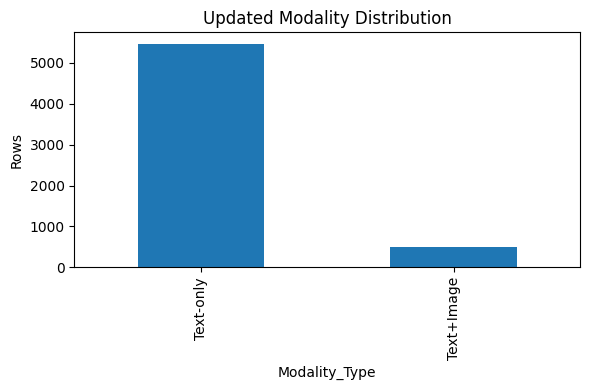

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

DATA = "/content/drive/MyDrive/msc_final_dataset/final_with_images_ocr.csv"

df = pd.read_csv(DATA)
mask = (df["Modality_Type"]=="Image-only") & (df["OCR_Text"].astype(str).str.strip().ne(""))
df.loc[mask, "Modality_Type"] = "Text+Image"
df.to_csv(DATA, index=False)

# Show updated counts:
print("Updated modality counts:")
print(df["Modality_Type"].value_counts())

df["Modality_Type"].value_counts().plot(kind="bar", figsize=(6,4), title="Updated Modality Distribution")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()

Show TOP 20 emojis in distribution:

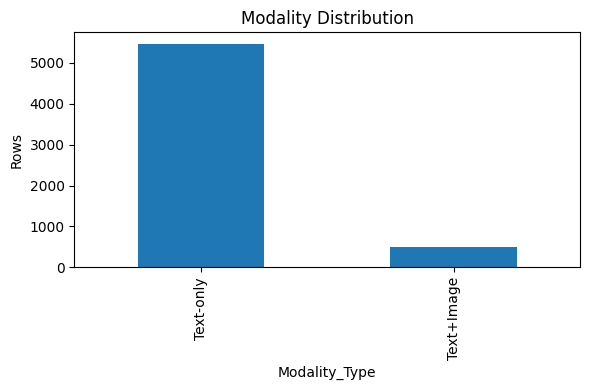

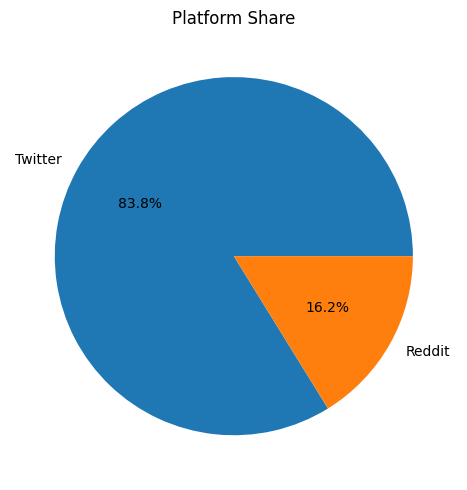

/tmp/ipython-input-3380247201.py:23: UserWarning: Glyph 129344 (\N{WILTED FLOWER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3380247201.py:23: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3380247201.py:23: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3380247201.py:23: UserWarning: Glyph 128149 (\N{TWO HEARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3380247201.py:23: UserWarning: Glyph 129309 (\N{HANDSHAKE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3380247201.py:23: UserWarning: Glyph 128062 (\N{PAW PRINTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3380247201.py:23: UserWarning: Glyph 128170 (\N{FLEXED BICEPS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3380247201.py:23: Us

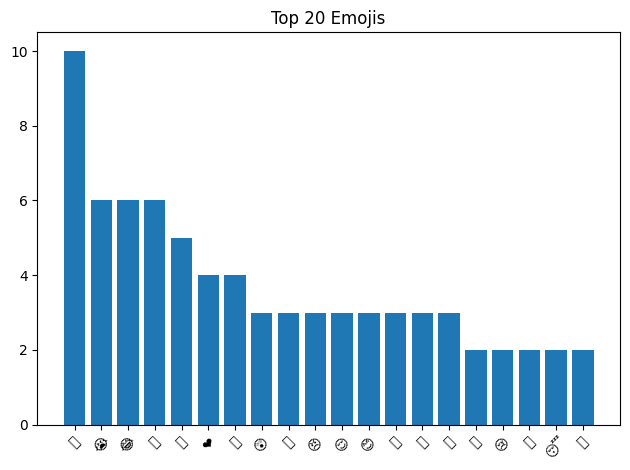

In [ ]:
import matplotlib.pyplot as plt

# Modality
df["Modality_Type"].value_counts().plot(kind="bar", figsize=(6,4), title="Modality Distribution")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()

# Platform
df["Social_Media_Type"].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(5,5), title="Platform Share")
plt.ylabel("")
plt.tight_layout()
plt.show()

# Emoji frequency (top 20)
from collections import Counter
all_emojis = "".join(df["Emoji"].dropna().astype(str))
top20 = Counter(all_emojis).most_common(20)
if top20:
    plt.bar([e for e,_ in top20],[c for _,c in top20])
    plt.title("Top 20 Emojis")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Before vs. After classification for Data Cleaning and Preprocessing:

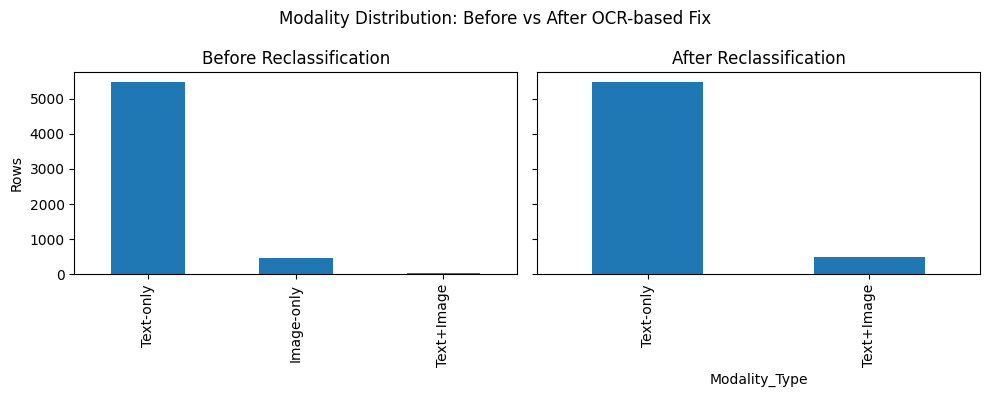

Before:
 Text-only     5475
Image-only     452
Text+Image      39
dtype: int64

After:
 Modality_Type
Text-only     5475
Text+Image     491
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

DATA = "/content/drive/MyDrive/msc_final_dataset/final_with_images_ocr.csv"
df = pd.read_csv(DATA)
after_counts = df["Modality_Type"].value_counts()
before_counts = pd.Series({
    "Text-only": 5475,
    "Image-only": 452,
    "Text+Image": 39
})

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)

before_counts.plot(kind="bar", ax=axes[0], title="Before Reclassification")
after_counts.plot(kind="bar", ax=axes[1], title="After Reclassification")

for ax in axes:
    ax.set_ylabel("Rows")

plt.suptitle("Modality Distribution: Before vs After OCR-based Fix")
plt.tight_layout()
plt.show()

print("Before:\n", before_counts)
print("\nAfter:\n", after_counts)

------------------------------

Lock in and save dataset:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# load reclassified dataset from last run
DATA = "/content/drive/MyDrive/msc_final_dataset/final_with_images_ocr.csv"
df = pd.read_csv(DATA)

print("Rows:", len(df))
print("Columns:", df.columns.tolist())
print(df.head(3))

Rows: 5966
Columns: ['Text', 'Emotion_Label', 'Emoji', 'Image_Reference', 'Subcommunity_Tag', 'Modality_Type', 'Social_Media_Type', 'Source', 'Image_Local_Path', 'local_path', 'status', 'OCR_Text', 'Text_Combined', 'Emoji_Extracted']
                                                Text Emotion_Label Emoji  \
0                       Can`t find any pictures  !!!           NaN   NaN   
1  RE: So, finally finished catching up with your...           NaN   NaN   
2                                             *hugs*           NaN   NaN   

  Image_Reference Subcommunity_Tag Modality_Type Social_Media_Type Source  \
0             NaN          Twitter     Text-only           Twitter    NaN   
1             NaN          Twitter     Text-only           Twitter    NaN   
2             NaN          Twitter     Text-only           Twitter    NaN   

  Image_Local_Path local_path                status OCR_Text  \
0              NaN        NaN  error(MissingSchema)      NaN   
1              NaN      

In [ ]:
SAVE_PATH = "/content/drive/MyDrive/msc_final_dataset/final_reclassified.csv"
df.to_csv(SAVE_PATH, index=False)
print("Saved locked dataset →", SAVE_PATH)

Saved locked dataset → /content/drive/MyDrive/msc_final_dataset/final_reclassified.csv


Exploratory Analysis:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd, os

DATA = "/content/drive/MyDrive/msc_final_dataset/final_with_images_ocr.csv"  # adjust if needed
assert os.path.exists(DATA), f"Missing file: {DATA}"

df = pd.read_csv(DATA)
print("Rows:", len(df))
print(sorted(df.columns))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Rows: 5966
['Emoji', 'Emoji_Extracted', 'Emotion_Label', 'Image_Local_Path', 'Image_Reference', 'Modality_Type', 'OCR_Text', 'Social_Media_Type', 'Source', 'Subcommunity_Tag', 'Text', 'Text_Combined', 'local_path', 'status']


In [ ]:
SAVE_PATH = "/content/drive/MyDrive/msc_final_dataset/final_reclassified.csv"
df.to_csv(SAVE_PATH, index=False)
print("Saved locked dataset →", SAVE_PATH)

Saved locked dataset → /content/drive/MyDrive/msc_final_dataset/final_reclassified.csv


In [ ]:
!pip -q install vaderSentiment

import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# check combined text exists
df["Text"] = df["Text"].fillna("").astype(str)
if "OCR_Text" not in df.columns:
    df["OCR_Text"] = ""
df["OCR_Text"] = df["OCR_Text"].fillna("").astype(str)
df["Text_Combined"] = (df["Text"] + " " + df["OCR_Text"]).str.strip()

an = SentimentIntensityAnalyzer()

def polarity_label(s: str):
    s = (s or "").strip()
    if not s: return "Neutral"
    c = an.polarity_scores(s)["compound"]
    if c >= 0.05: return "Positive"
    if c <= -0.05: return "Negative"
    return "Neutral"

df["Polarity_Label"] = df["Text_Combined"].apply(polarity_label)

# Quick counts
print("\n=== Polarity overall ===")
print(df["Polarity_Label"].value_counts())

print("\n=== Polarity by Platform ===")
print(df.groupby("Social_Media_Type")["Polarity_Label"].value_counts(normalize=True).round(3))

print("\n=== Polarity by Modality ===")
print(df.groupby("Modality_Type")["Polarity_Label"].value_counts(normalize=True).round(3))

# Save snapshot
POL_PATH = "/content/drive/MyDrive/msc_final_dataset/final_with_polarity.csv"
df.to_csv(POL_PATH, index=False)
print("\nSaved with polarity →", POL_PATH)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00

=== Polarity overall ===
Polarity_Label
Positive    2921
Negative    1552
Neutral     1493
Name: count, dtype: int64

=== Polarity by Platform ===
Social_Media_Type  Polarity_Label
Reddit             Positive          0.552
                   Negative          0.293
                   Neutral           0.155
Twitter            Positive          0.478
                   Neutral           0.269
                   Negative          0.254
Name: proportion, dtype: float64

=== Polarity by Modality ===
Modality_Type  Polarity_Label
Text+Image     Positive          0.527
               Neutral           0.293
               Negative          0.179
Text-only      Positive          0.486
               Negative          0.267
               Neutral           0.246
Name: proportion, dtype: float64

Saved with polarity → /content/drive/MyDrive/msc_final_dataset/final_with_polarity.csv


**Polarity Analysis (VADER)**

Polarity distribution:
 Polarity_Label
Positive    2921
Negative    1552
Neutral     1493
Name: count, dtype: int64


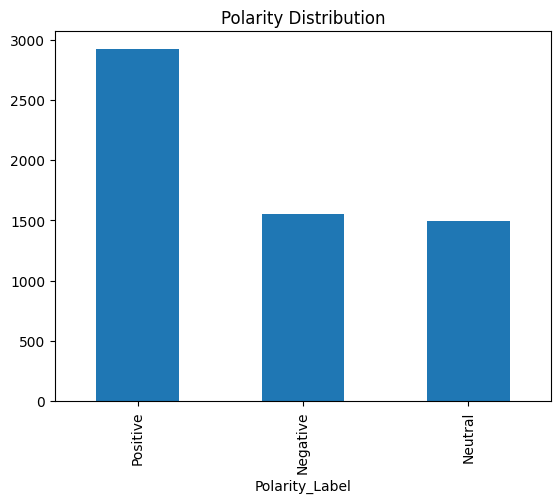

In [ ]:
!pip install vaderSentiment


import matplotlib.pyplot as plt
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_polarity(text):
    if pd.isna(text) or not str(text).strip():
        return None
    scores = analyzer.polarity_scores(str(text))
    comp = scores['compound']
    if comp >= 0.05:
        return "Positive"
    elif comp <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Combine text + OCR for polarity analysis
df["Combined_Text"] = df["Text"].fillna("") + " " + df.get("OCR_Text", "").fillna("")
df["Polarity_Label"] = df["Combined_Text"].apply(get_polarity)

print("Polarity distribution:\n", df["Polarity_Label"].value_counts(dropna=False))

# Plot visual
df["Polarity_Label"].value_counts().plot(kind="bar", title="Polarity Distribution")
plt.show()

**Emoji Grouping (into sentiment buckets)**

In [ ]:
# Define simple emoji sentiment groups
positive_emojis = set("😀😃😄😁😆😊🙂😍😘🥰🤣😂😅😉😎🤩🎉❤️💕")
negative_emojis = set("😢😭😡🤬😠😞😔🙁😩😫😖")
neutral_emojis  = set("😐😶🤔😑😴😏😬")

def classify_emoji(e):
    if not isinstance(e, str):
        return None
    bucket = []
    for char in e:
        if char in positive_emojis:
            bucket.append("Positive")
        elif char in negative_emojis:
            bucket.append("Negative")
        elif char in neutral_emojis:
            bucket.append("Neutral")
    return list(set(bucket)) if bucket else None

df["Emoji_Sentiment"] = df["Emoji"].apply(classify_emoji)

print("Emoji sentiment coverage:\n", df["Emoji_Sentiment"].value_counts(dropna=False))

Emoji sentiment coverage:
 Emoji_Sentiment
None                    5930
[Positive]                19
[Negative]                10
[Neutral]                  5
[Positive, Negative]       2
Name: count, dtype: int64


**Export Example Multimodal Samples**

In [ ]:
# Select 6 random multimodal samples (Text+Image rows)
examples = df[df["Modality_Type"]=="Text+Image"].sample(6, random_state=42)

examples_out = examples[["Text", "Emoji", "Image_Local_Path", "OCR_Text"]]
print(examples_out)

# Save for dissertation table
examples_out.to_csv("/content/drive/MyDrive/msc_final_dataset/multimodal_examples.csv", index=False)
print("Saved multimodal examples → multimodal_examples.csv")

                                Text Emoji  \
5925             Took it for granite   NaN   
5545         We don't deserve Gnomes   NaN   
5907             Well you see son...   NaN   
5947    Nowadays no Netflix no chill   NaN   
5901  Me after seeing certain people   NaN   
5782     cats are cute little angles   NaN   

                                       Image_Local_Path  \
5925  /content/drive/MyDrive/dataset_images/ff27a237...   
5545  /content/drive/MyDrive/dataset_images/eeb05b4d...   
5907  /content/drive/MyDrive/dataset_images/ecbf114a...   
5947  /content/drive/MyDrive/dataset_images/771edd13...   
5901  /content/drive/MyDrive/dataset_images/7753c493...   
5782  /content/drive/MyDrive/dataset_images/a7e8b7fd...   

                                               OCR_Text  
5925  The boys after you make even the slightest gra...  
5545  “And with the Gnome Kingdom's contribution, th...  
5907         -MUMMY HOW ARE WE ABLE ~ 10 Pa SUCHA PVT a  
5947  lM NOT STRAIGHT Amy Ordma

**Text embeddings (SBERT) + KMeans (k=8) + cluster “top-terms” table**

In [ ]:
!pip -q install sentence-transformers scikit-learn

import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer

texts = df["Text_Combined"].fillna("").astype(str).tolist()

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
E_text = model.encode(texts, batch_size=128, show_progress_bar=True, normalize_embeddings=True)

# KMeans (k=8 matches Plutchik primaries; fine for baseline)
k = 8
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
labels = kmeans.fit_predict(E_text)
df["Cluster_SBERT_k8"] = labels

# Silhouette as sanity
try:
    sil = silhouette_score(E_text, labels, metric="cosine")
except Exception:
    sil = float("nan")
print("Silhouette (cosine):", sil)

# "Top terms" per cluster via TF-IDF on cluster members
vec = TfidfVectorizer(max_features=50000, ngram_range=(1,2), min_df=5)
X = vec.fit_transform(df["Text_Combined"].fillna("").astype(str))
vocab = np.array(vec.get_feature_names_out())

top_terms = {}
for c in range(k):
    idx = np.where(labels==c)[0]
    if len(idx)==0:
        top_terms[c] = []
        continue
    # sum TF-IDF within cluster
    scores = X[idx].sum(axis=0).A1
    top_idx = scores.argsort()[::-1][:12]
    top_terms[c] = vocab[top_idx].tolist()

# Save !!
import os, json
EMB_DIR = "/content/drive/MyDrive/msc_final_dataset/embeddings"; os.makedirs(EMB_DIR, exist_ok=True)
np.save(f"{EMB_DIR}/sbert_embeddings.npy", E_text)
df.to_csv("/content/drive/MyDrive/msc_final_dataset/final_with_polarity_sbert.csv", index=False)
with open(f"{EMB_DIR}/cluster_top_terms.json","w") as f: json.dump(top_terms, f, indent=2)

print("Saved SBERT embeddings + clustered dataset.")
print("\nTop terms per cluster:")
for c, terms in top_terms.items():
    print(f"Cluster {c}: {', '.join(terms[:10])}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Silhouette (cosine): 0.03078865
Saved SBERT embeddings + clustered dataset.

Top terms per cluster:
Cluster 0: the, it, to, my, on, http, twitter, for, you, and
Cluster 1: you, the, to, me, it, that, my, is, of, your
Cluster 2: day, happy, mother, mothers, mother day, happy mother, mothers day, happy mothers, day to, mom
Cluster 3: and, to, he, my, the, me, it, she, that, of
Cluster 4: the, to, and, it, is, on, watching, that, of, my
Cluster 5: to, the, you, in, it, and, my, for, be, go
Cluster 6: my, the, and, to, it, of, is, just, for, in
Cluster 7: to, work, and, morning, today, day, the, sleep, night, at


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, pandas as pd, numpy as np

DATA = "/content/drive/MyDrive/msc_final_dataset/final_with_polarity_sbert.csv"  # file w/ Cluster_SBERT_k8
assert os.path.exists(DATA), f"Missing: {DATA}"
df = pd.read_csv(DATA)
assert "Cluster_SBERT_k8" in df.columns, "Run the SBERT clustering step first."
print("Rows:", len(df), "| Columns:", len(df.columns))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Rows: 5966 | Columns: 18


**Cluster size distribution (figure + CSV)**

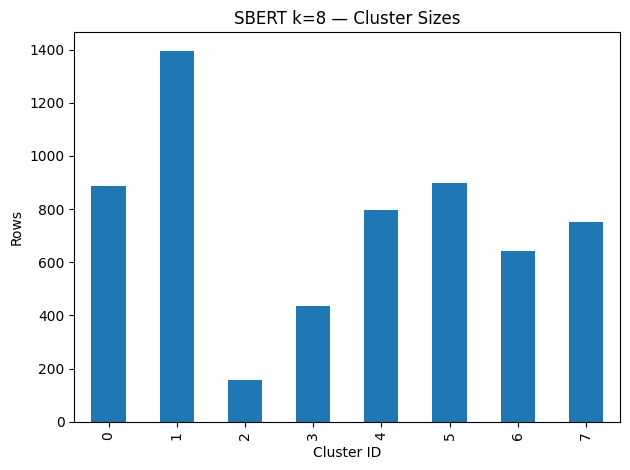

Saved cluster sizes → cluster_sizes.csv


In [ ]:
import matplotlib.pyplot as plt

sizes = df["Cluster_SBERT_k8"].value_counts().sort_index()
sizes.plot(kind="bar", title="SBERT k=8 — Cluster Sizes")
plt.xlabel("Cluster ID"); plt.ylabel("Rows"); plt.tight_layout(); plt.show()

sizes.to_csv("/content/drive/MyDrive/msc_final_dataset/cluster_sizes.csv", header=["count"])
print("Saved cluster sizes → cluster_sizes.csv")

**Top terms per cluster (stopword-cleaned) → table CSV**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Clean text a bit for TF-IDF
text_series = df["Text_Combined"].fillna("").astype(str).str.replace(r"http\S+"," ", regex=True)

# Extra stopwords to kill junk terms you saw earlier
extra_sw = {
    "the","to","and","it","is","of","in","on","for","you","my","me","that","your","just","today",
    "http","https","com","twitter","www","amp"
}
vec = TfidfVectorizer(
    stop_words="english",
    max_features=50000,
    min_df=5,
    ngram_range=(1,2),
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b"  # words ≥2 letters
)
X = vec.fit_transform(text_series)
vocab = np.array(vec.get_feature_names_out())

top_terms = []
for c in sorted(df["Cluster_SBERT_k8"].unique()):
    idx = np.where(df["Cluster_SBERT_k8"].values == c)[0]
    if len(idx)==0:
        top_terms.append([c, 0, []]); continue
    scores = X[idx].sum(axis=0).A1
    order = scores.argsort()[::-1]
    terms = []
    for j in order:
        t = vocab[j]
        if t.lower() in extra_sw:
            continue
        terms.append(t)
        if len(terms) == 12:
            break
    top_terms.append([c, len(idx), terms])

tt_df = pd.DataFrame(top_terms, columns=["Cluster","Size","Top_Terms"])
tt_df.to_csv("/content/drive/MyDrive/msc_final_dataset/cluster_top_terms_table.csv", index=False)
print("Saved → cluster_top_terms_table.csv")
tt_df

Saved → cluster_top_terms_table.csv


,Cluster,Size,Top_Terms
0,0,888,"[thanks, new, phone, work, got, working, like,..."
1,1,1395,"[know, oc, lol, like, love, good, say, don, ha..."
2,2,157,"[day, happy, mother, mothers, mother day, happ..."
3,3,437,"[like, don, feel, know, ve, want, time, relati..."
4,4,796,"[watching, miss, love, good, watch, movie, mis..."
5,5,899,"[day, going, weekend, wish, home, rain, good, ..."
6,6,644,"[headache, got, like, eat, hurts, food, good, ..."
7,7,750,"[work, morning, day, sleep, bed, home, night, ..."


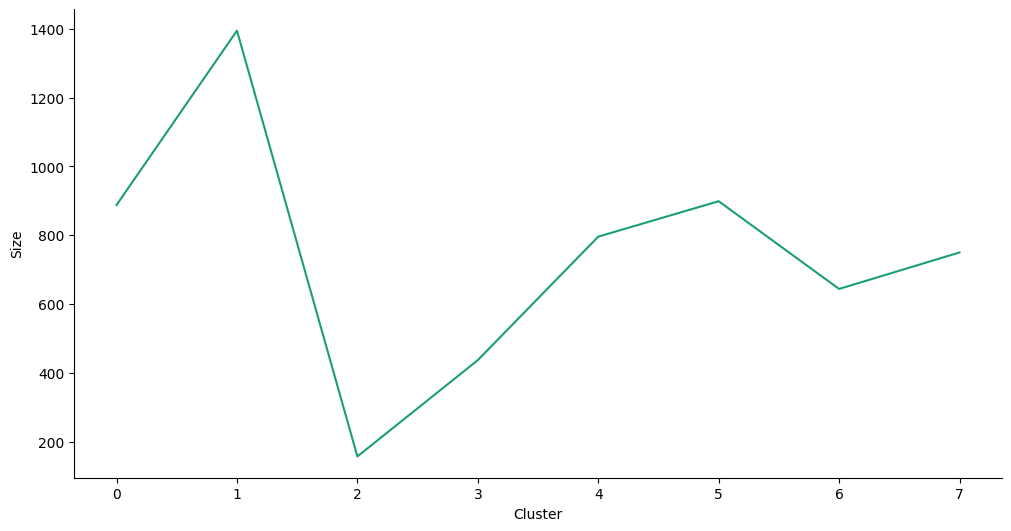

In [ ]:
# Cluster vs Size

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Cluster']
  ys = series['Size']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = tt_df.sort_values('Cluster', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Cluster')
_ = plt.ylabel('Size')

**Polarity mix per cluster (stacked bar + CSV)**

Saved → cluster_polarity_mix.csv


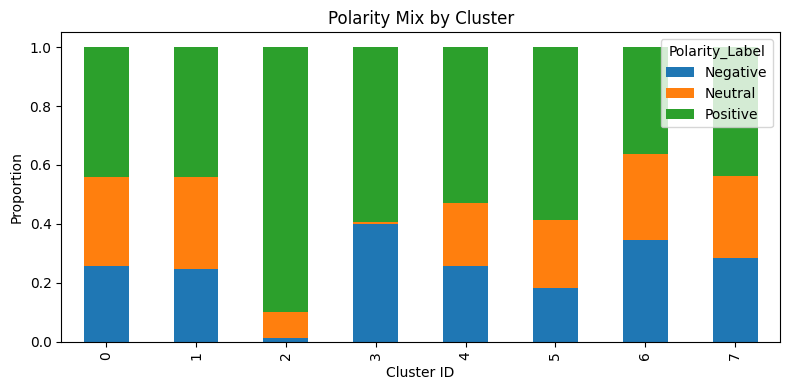

In [ ]:
# Crosstab proportions
ct = pd.crosstab(df["Cluster_SBERT_k8"], df["Polarity_Label"], normalize="index").fillna(0).sort_index()
ct.to_csv("/content/drive/MyDrive/msc_final_dataset/cluster_polarity_mix.csv")
print("Saved → cluster_polarity_mix.csv")

# Stacked bar
ax = ct.plot(kind="bar", stacked=True, title="Polarity Mix by Cluster", figsize=(8,4))
ax.set_xlabel("Cluster ID"); ax.set_ylabel("Proportion")
plt.tight_layout(); plt.show()

**Example posts per cluster (table) — 2 examples each**

In [ ]:
examples = []
rng = np.random.default_rng(42)
for c in sorted(df["Cluster_SBERT_k8"].unique()):
    g = df[df["Cluster_SBERT_k8"]==c]
    take = min(len(g), 2)
    ex = g.sample(take, random_state=42)[["Text","OCR_Text","Emoji","Social_Media_Type","Modality_Type","Image_Local_Path"]]
    ex.insert(0, "Cluster", c)
    examples.append(ex)
ex_df = pd.concat(examples, ignore_index=True)
ex_path = "/content/drive/MyDrive/msc_final_dataset/cluster_examples_2_each.csv"
ex_df.to_csv(ex_path, index=False)
print("Saved →", ex_path)
ex_df.head(12)

Saved → /content/drive/MyDrive/msc_final_dataset/cluster_examples_2_each.csv


,Cluster,Text,OCR_Text,Emoji,Social_Media_Type,Modality_Type,Image_Local_Path
0,0,Located & ordered a new cooker today. Feel I`v...,NaN,NaN,Twitter,Text-only,NaN
1,0,"Had a great day, apart from the fact that I bo...",NaN,NaN,Twitter,Text-only,NaN
2,1,Fight for it with positive action and working ...,"ct IN THE END, IT'S ONLY A PASSING THING, THIS...",NaN,Reddit,Text+Image,/content/drive/MyDrive/dataset_images/fcb06cef...
3,1,"don`t 4get Gina Thomas! ( the things u do, kee...",NaN,NaN,Twitter,Text-only,NaN
4,2,"Feeling very grateful for such a great Mum, an...",NaN,NaN,Twitter,Text-only,NaN
5,2,oh yeah... happy Mothers day to every mom out ...,NaN,NaN,Twitter,Text-only,NaN
6,3,Found out I have a younger half brother-Is it ...,NaN,NaN,Reddit,Text-only,NaN
7,3,My dad died when I was 16\n\nSo when I was 16 ...,NaN,NaN,Reddit,Text-only,NaN
8,4,mcfly anit been on here in ages z,NaN,NaN,Twitter,Text-only,NaN
9,4,Disneys only save and grace is marvel,Making good original Films and listening To th...,NaN,Reddit,Text+Image,/content/drive/MyDrive/dataset_images/2b89475d...


**2D map of clusters with UMAP**

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


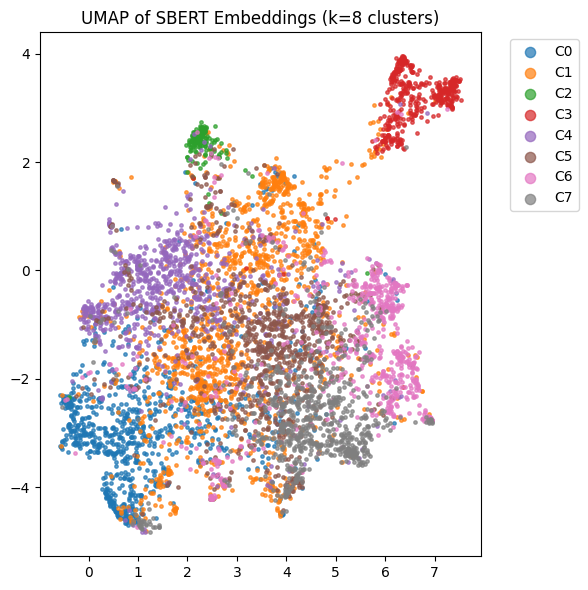

Saved UMAP coords → umap_coords.csv


In [ ]:
!pip -q install umap-learn

import numpy as np, umap
import matplotlib.pyplot as plt

E_text = np.load("/content/drive/MyDrive/msc_final_dataset/embeddings/sbert_embeddings.npy")  # from earlier step
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
Z = reducer.fit_transform(E_text)
df_umap = pd.DataFrame({"x":Z[:,0],"y":Z[:,1],"cluster":df["Cluster_SBERT_k8"].values})

plt.figure(figsize=(6,6))
for c in sorted(df_umap["cluster"].unique()):
    sub = df_umap[df_umap["cluster"]==c]
    plt.scatter(sub["x"], sub["y"], s=6, label=f"C{c}", alpha=0.7)
plt.title("UMAP of SBERT Embeddings (k=8 clusters)")
plt.legend(markerscale=3, bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout(); plt.show()

df_umap.to_csv("/content/drive/MyDrive/msc_final_dataset/umap_coords.csv", index=False)
print("Saved UMAP coords → umap_coords.csv")

**Cluster summary sheet (sizes + top terms string)**

In [ ]:
sum_df = tt_df[["Cluster","Size","Top_Terms"]].copy()
sum_df["Top_Terms"] = sum_df["Top_Terms"].apply(lambda lst: ", ".join(lst[:10]))
sum_df.to_csv("/content/drive/MyDrive/msc_final_dataset/cluster_summary_sheet.csv", index=False)
print("Saved → cluster_summary_sheet.csv")
sum_df

Saved → cluster_summary_sheet.csv


,Cluster,Size,Top_Terms
0,0,888,"thanks, new, phone, work, got, working, like, ..."
1,1,1395,"know, oc, lol, like, love, good, say, don, hah..."
2,2,157,"day, happy, mother, mothers, mother day, happy..."
3,3,437,"like, don, feel, know, ve, want, time, relatio..."
4,4,796,"watching, miss, love, good, watch, movie, miss..."
5,5,899,"day, going, weekend, wish, home, rain, good, h..."
6,6,644,"headache, got, like, eat, hurts, food, good, n..."
7,7,750,"work, morning, day, sleep, bed, home, night, t..."
